### Setup

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mexican_holidays_ import mexican_holidays
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb
import plotly.graph_objs as go

### Loading and preprocessing data

In [31]:
# Load data
data = pd.read_csv('weekly_clean_data_.csv')

# Data transformation: convert date column to datetime
data['ds'] = pd.to_datetime(data['ds'], format='%Y-%m-%d') 

# Add holiday indicator using vectorized assignment
data['holiday'] = 0

mexican_holidays_dates = mexican_holidays
data.loc[data['ds'].isin(mexican_holidays_dates), 'holiday'] = 1

# Create holidays dataframe for Prophet
holidays_df = pd.DataFrame({
    'holiday':'holi',
    'ds': pd.to_datetime(mexican_holidays_dates),
    'lower_window': -7,
    'upper_window': 3
})

# Mark holidays in data
for i, row in holidays_df.iterrows():
    data.loc[data['ds'] == row['ds'], 'holiday'] = 1

# Remove holiday column if not needed further
data = data.drop(columns=['holiday'])

data.head()

,ds,y,Price
0,2019-01-06,4.682682e+06,21.18692
1,2019-01-13,6.736127e+06,21.66080
2,2019-01-20,6.111553e+06,21.74350
3,2019-01-27,6.863234e+06,21.22170
4,2019-02-03,7.336746e+06,20.65344


### Prepare training and test sets

In [21]:
# Assume data is weekly
test_weeks = 4
training_set = data.iloc[:-test_weeks, :]
test_set = data.iloc[-test_weeks:, :]

### Fit Prophet Model

In [22]:
# Initialize Prophet model

m = Prophet(yearly_seasonality=True,
            weekly_seasonality=False,
            daily_seasonality=False,
            holidays=holidays_df,
            seasonality_mode='multiplicative',
            seasonality_prior_scale=5,
            holidays_prior_scale=5,
            changepoint_prior_scale=0.05)

m.add_regressor('Price')

m.fit(training_set)

# Create a future dataframe that spans the test period
future = m.make_future_dataframe(periods=len(test_set), freq='W')

future = pd.concat([future, data.iloc[:, 2:]], axis=1)

# Generate forecast
forecast = m.predict(future)

# Key Prophet features for merging with XGBoost
prophet_features = forecast[['ds', 'trend', 'holi', 'yearly']]

17:51:22 - cmdstanpy - INFO - Chain [1] start processing
17:51:22 - cmdstanpy - INFO - Chain [1] done processing


### Merge features with XGBoost

In [23]:
df_xgb = pd.merge(data, prophet_features, on='ds', how='left')

df_xgb.head()

,ds,y,Price,trend,holi,yearly
0,2019-01-06,4.682682e+06,21.18692,6.588597e+06,0.031222,-0.409719
1,2019-01-13,6.736127e+06,21.66080,6.587526e+06,0.000000,-0.264470
2,2019-01-20,6.111553e+06,21.74350,6.586455e+06,0.000000,-0.146844
3,2019-01-27,6.863234e+06,21.22170,6.585384e+06,0.000000,-0.145264
4,2019-02-03,7.336746e+06,20.65344,6.584313e+06,0.000000,-0.218572


### Prepare data for XGBoost

In [24]:
if 'index' in df_xgb.columns:
    df_xgb = df_xgb.drop(columns=['index'])

training_set_xgb = df_xgb.iloc[:-test_weeks, :]
test_set_xgb = df_xgb.iloc[-test_weeks:, :]

y_train = training_set_xgb['y']
y_test = test_set_xgb['y']
X_train = training_set_xgb.drop(columns=['ds', 'y'])
X_test = test_set_xgb.drop(columns=['ds', 'y'])

### Train XGBoost Model

In [25]:
# Matrix objects
Train = xgb.DMatrix(X_train, label=y_train)
Test = xgb.DMatrix(X_test, label=y_test)

parameters = {
    'learning_rate': 0.01, 
    'max_depth': 5, 
    'colsample_bytree': 1,
    'min_child_weight': 1,
    'gamma': 0, 
    'random_state': 1502,
    'eval_metric': 'rmse',
    'objective': 'reg:squarederror'
}

model_xgb = xgb.train(params=parameters,
                      dtrain=Train,
                      num_boost_round=100,
                      evals=[[Test, 'Test']],
                      verbose_eval=15)

predictions_xgb = pd.Series(model_xgb.predict(Test), name='XGBoost')
predictions_xgb.index = pd.to_datetime(test_set_xgb['ds'])
print(predictions_xgb)

[0]	Test-rmse:988759.99816
[15]	Test-rmse:885277.16696
[30]	Test-rmse:832122.24667
[45]	Test-rmse:783046.59687
[60]	Test-rmse:705420.00371
[75]	Test-rmse:595166.93026
[90]	Test-rmse:548738.05645
[99]	Test-rmse:549842.69320
ds
2024-05-12    5418573.5
2024-05-19    6498462.0
2024-05-26    6865682.0
2024-06-02    7495677.0
Name: XGBoost, dtype: float32


### Visualization

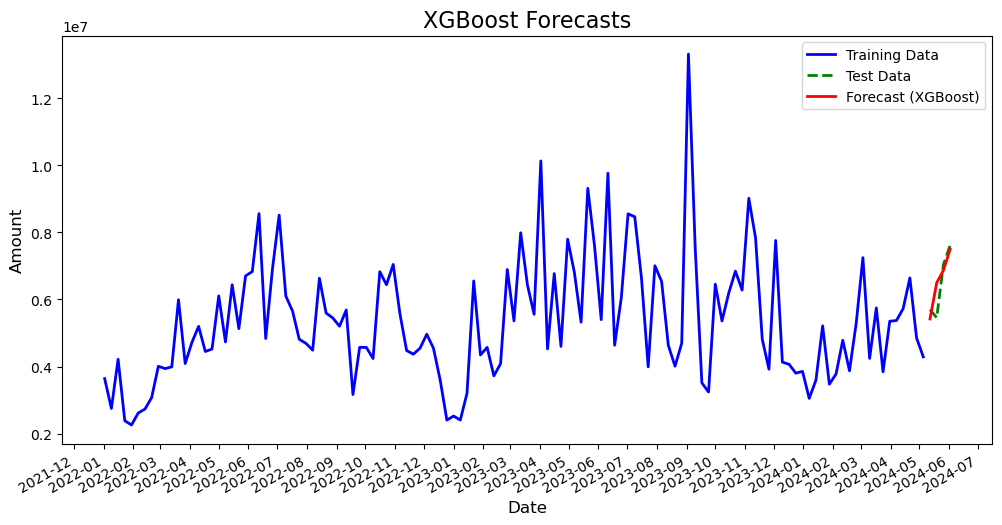

In [29]:
def plot_forecasts(training_set, test_set, predictions, title='XGBoost Forecasts', start_date='2022-01-01'):
    start_date = pd.to_datetime(start_date)

    fig, ax = plt.subplots(figsize=(12, 6))

    #Filter data based on start_date
    training_filtered = training_set[training_set['ds'] >= start_date]
    predictions_filtered = predictions[predictions.index >= start_date]

    # Plot training data
    ax.plot(training_filtered['ds'], training_filtered['y'], label='Training Data', color='blue',linewidth=2)

    # Plot test data
    ax.plot(test_set['ds'], test_set['y'], label='Test Data', color='green', linewidth=2, linestyle='dashed')

    # Plot forecasts
    ax.plot(predictions_filtered.index, predictions_filtered, label = 'Forecast (XGBoost)', color='red', linewidth=2)

    # Format x-axis dates
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    fig.autofmt_xdate()

    # Set title and labels
    ax.set_xlabel('Date',fontsize=12)
    ax.set_ylabel('Amount',fontsize=12)
    ax.set_title(title, fontsize=16)
    ax.legend()

    plt.show()

plot_forecasts(training_set, test_set, predictions_xgb, title='XGBoost Forecasts', start_date='2022-01-01')



### Model Evaluation

In [27]:
mae = mean_absolute_error(test_set_xgb['y'], predictions_xgb)
rmse = np.sqrt(mean_squared_error(test_set_xgb['y'], predictions_xgb))

def MAPE(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = MAPE(test_set_xgb['y'], predictions_xgb)

print('MAE:', round(mae, 0))
print('RMSE:', round(rmse, 0))
print('MAPE:', mape)

MAE: 402814.0
RMSE: 549843.0
MAPE: 7.000583071932325
